In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# from majorroutines import targeting
from utils import common
from utils import kplotlib as kpl
from utils import tool_belt as tb
from pulsestreamer import PulseStreamer
import TimeTagger as ttag
import pulsestreamer as ps
import time

In [2]:
import sys
print(sys.path)

['c:\\Users\\kolko\\Documents\\GitHub\\dioptric\\majorroutines\\spectroscopy', 'C:\\Users\\kolko\\Documents\\GitHub\\dioptric', 'C:\\Program Files\\Swabian Instruments\\Time Tagger\\driver\\python', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv\\Scripts\\python313.zip', 'C:\\Users\\kolko\\AppData\\Roaming\\uv\\python\\cpython-3.13.2-windows-x86_64-none\\DLLs', 'C:\\Users\\kolko\\AppData\\Roaming\\uv\\python\\cpython-3.13.2-windows-x86_64-none\\Lib', 'C:\\Users\\kolko\\AppData\\Roaming\\uv\\python\\cpython-3.13.2-windows-x86_64-none', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv', '', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv\\Lib\\site-packages', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\kolko\\Documents\\uv\\dioptric\\.venv\\Lib\\site-packages\\Pythonwin', 'C:\\Program Files\\Swabian Instruments\\Time Tagger\\driver\\x64']


In [14]:
### Create the Pulse Sequence
pulse_dur = 50e-6 / 1e-9
wait = 10e-6/1e-9
decay_period = 50e-3 / 1e-9

pulser = PulseStreamer('192.168.0.111')

# Channel names
optical_ch = 0  # 515 laser
gate_ch = 4  # Time Tagger

# Digital levels
HIGH=1
LOW=0

# Change the values according to your experiment
# Optical pattern
optical_patt = [(wait, LOW), (pulse_dur, HIGH), (decay_period, LOW)]

# Pattern for sync
gate_patt = [(wait, LOW), (pulse_dur,HIGH), (decay_period, LOW)]

# Set channels using class Sequence
seq = pulser.createSequence()
seq.setDigital(optical_ch, optical_patt)
seq.setDigital(gate_ch, gate_patt)

tagger = ttag.createTimeTagger()
gate = 2  # Pulse Streamer TTL
detector = 1 # APD Channel
binwidth = 1e-6 / 1e-12  # in picoseconds
# n_bins = int(decay_period * 1e3)
n_bins = 1e5
print(n_bins)
lifetime = ttag.Correlation(
    tagger,
    gate,        # falling edge of laser TTL
    detector,
    1.0e6,
    n_bins
)

lifetime.start()
pulser.stream(seq, n_runs=5)

while pulser.isStreaming():
    time.sleep(0.01)  # polling

tagger.sync()
lifetime.stop()

counts = lifetime.getData()
time_axis = lifetime.getIndex() * binwidth * 1e-12  # ps → s

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.0.111
Pulse Streamer 8/2 firmware: v1.6.3
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com
100000.0


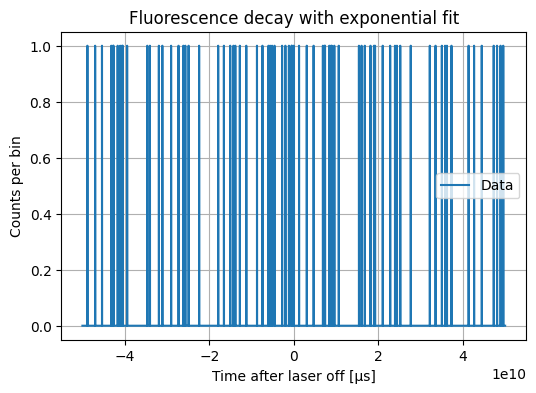

In [15]:
plt.figure(figsize=(6,4))
plt.plot(time_axis*1e6, counts, drawstyle='steps-mid', label='Data')
plt.xlabel('Time after laser off [µs]')
plt.ylabel('Counts per bin')
plt.title('Fluorescence decay with exponential fit')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
state = ps.OutputState([0])

pulser.constant(state)

In [36]:
pulser.reset()

0

In [5]:
### Create the Pulse Sequence
pulser_ts = 1e-9
wait = 1e-6
pulse_dur = 5e-6 
decay_period = 1e-6 
total_time = pulse_dur + wait + decay_period

pulser = PulseStreamer('192.168.0.111')

# Channel names
optical_ch = 0  # 515 laser

# Digital levels
HIGH=1
LOW=0

optical_patt = [(5e-6/pulser_ts, LOW), (5e-6/pulser_ts, HIGH), (5e-6/pulser_ts, LOW)]


# Set channels using class Sequence
seq = pulser.createSequence()
seq.setDigital(optical_ch, optical_patt)


tagger = ttag.createTimeTagger()

pulser.stream(seq, n_runs=5)
total_count = ttag.Counter(
        tagger=tagger, 
        channels=[1], 
        binwidth=1e-9 / 1e-12, 
        n_values=20e-6 / 1e-12
    )
time.sleep(50e-6)

data = total_count.getData()[0]

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.0.111
Pulse Streamer 8/2 firmware: v1.6.3
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com


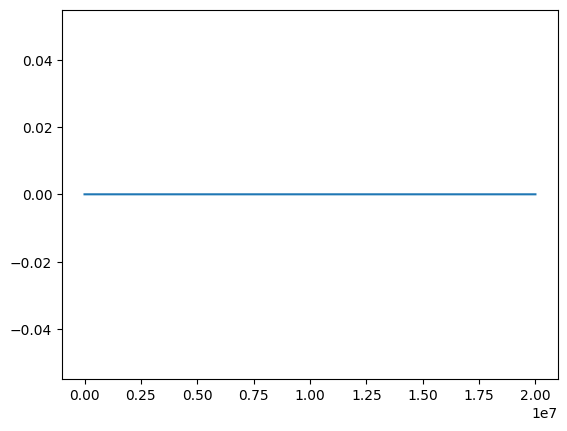

In [6]:
fig, ax = plt.subplots()
ax.plot(data)

In [43]:
del tagger

In [4]:
time_axis

array([-50000., -49999., -49998., ...,  49997.,  49998.,  49999.])

In [ ]:
# Simple exponential decay function
def exp_decay(t, A, tau, B):
    return A * np.exp(-t/tau) + B

# Fit only after time zero, e.g., exclude pre-trigger
popt, pcov = scipy.curve_fit(exp_decay, time_axis, counts, p0=[max(counts), 1e-6, min(counts)])
A, tau, B = popt

plt.figure(figsize=(6,4))
plt.plot(time_axis*1e6, counts, drawstyle='steps-mid', label='Data')
plt.plot(time_axis*1e6, exp_decay(time_axis, *popt), 'r--', label=f'Fit: tau={tau*1e6:.2f} µs')
plt.xlabel('Time after laser off [µs]')
plt.ylabel('Counts per bin')
plt.title('Fluorescence decay with exponential fit')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: Module 'scipy' has no attribute 'curve_fit'